Используя тип нейронной сети RNN LSTM-GRU сделайте прогноз развития уровня углекислого газа, используя следующие данные  .Поле“interpolated” содержит тренд развития уровня CO2, поля “year” и “month” содержат годи месяц соответственно


RMSE означает Root Mean Square Error (квадратный корень из среднего квадратичного отклонения). Это популярная метрика для оценки качества моделей машинного обучения, особенно в задачах регрессии.

RMSE измеряет стандартное отклонение разности между предсказанными и реальными значениями. Другими словами, он показывает, насколько предсказание модели отклоняется от фактического значения.

Меньшее значение RMSE указывает на меньшую разницу между предсказанными и реальными значениями, что является индикатором более высокого качества модели. Однако, RMSE не идеальна и может быть чувствительна к выбросам. Это означает, что даже одно или несколько очень плохих предсказаний могут значительно увеличить ваше значение RMSE.

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, GRU
import matplotlib.pyplot as plt
import math

# преобразование данных в последовательности
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [5]:
data = pd.read_csv('co2_mm_mlo.csv', sep=';')
data.head(10)

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,-99.99,317.10
4,1958,7,1958.542,315.86,315.86
5,1958,8,1958.625,314.93,314.93
6,1958,9,1958.708,313.20,313.20
7,1958,10,1958.792,-99.99,312.66
8,1958,11,1958.875,313.33,313.33
9,1958,12,1958.958,314.67,314.67


In [6]:
# Нормализуем данные
scaler = MinMaxScaler(feature_range=(0, 1))
data['normalized'] = scaler.fit_transform(data['interpolated'].values.reshape(-1,1))

In [7]:
# Деление данных на тренировочную и тестовую выборки
train_data = data[data['year'] < 2010]
test_data = data[data['year'] >= 2010]

# Преобразование данных в последовательности
look_back = 3
trainX, trainY = create_dataset(train_data['normalized'].values, look_back)
testX, testY = create_dataset(test_data['normalized'].values, look_back)

# Форма данных для подачи в GRU
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# GRU
model = Sequential()
model.add(GRU(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=30, batch_size=32)

Epoch 1/30
20/20 [==============================] - 2s 3ms/step - loss: 0.0940
Epoch 2/30
20/20 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 3/30
20/20 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 4/30
20/20 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 5/30
20/20 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 6/30
20/20 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 7/30
20/20 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 8/30
20/20 [==============================] - 0s 3ms/step - loss: 8.8398e-04
Epoch 9/30
20/20 [==============================] - 0s 3ms/step - loss: 5.9339e-04
Epoch 10/30
20/20 [==============================] - 0s 3ms/step - loss: 4.9342e-04
Epoch 11/30
20/20 [==============================] - 0s 2ms/step - loss: 4.6954e-04
Epoch 12/30
20/20 [==============================] - 0s 3ms/step - loss: 4.5978e-04
Epoch 13/30
20/20 [==========

In [8]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Преобразование предсказанных значений к исходному масштабу
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# RMSE (root mean squared error)
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

3/3 [==============================] - 0s 4ms/step
Train Score: 1.97 RMSE
Test Score: 2.47 RMSE


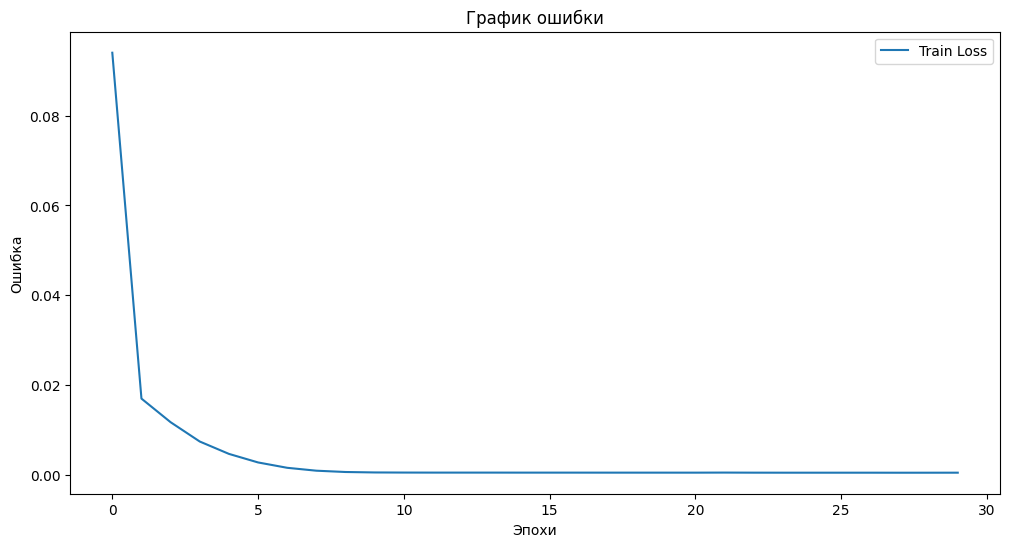

In [12]:
# График ошибки
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.title('График ошибки')
plt.xlabel('Эпохи')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

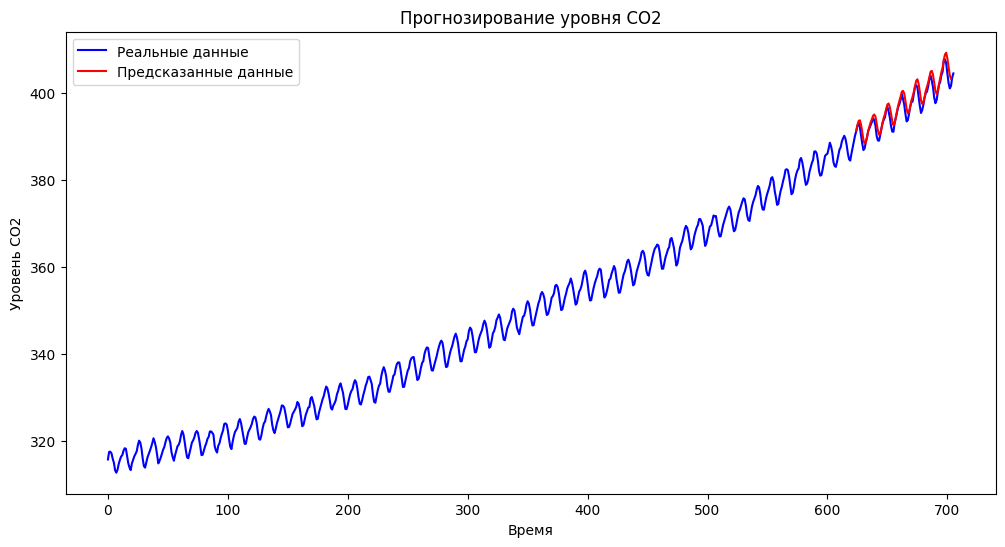

In [13]:
plt.figure(figsize=(12,6))
plt.plot(data['interpolated'].values, color='blue', label='Реальные данные')
plt.plot(range(len(trainPredict)+(2*look_back),len(trainPredict)+len(testPredict)+(2*look_back)), testPredict.flatten(), color='red', label='Предсказанные данные')
plt.title('Прогнозирование уровня CO2')
plt.xlabel('Время')
plt.ylabel('Уровень CO2')
plt.legend()
plt.show()